<a href="https://colab.research.google.com/github/karthickgopalswamy/Notes/blob/master/Estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimator API: MNIST dataset 


In [0]:
import numpy as np
import shutil
import os
import tensorflow as tf
print(tf.__version__)
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

1.12.0


In [0]:
input_data = tf.keras.datasets.mnist
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = input_data.load_data()
mnist_train_images = mnist_train_images.astype(np.float32)
mnist_test_images = mnist_test_images.astype(np.float32)
print(mnist_train_images.shape)
print(mnist_train_labels.shape)

(60000, 28, 28)
(60000,)


In [0]:
HEIGHT=28
WIDTH=28
NCLASSES=10
# mnist_train_labels = tf.keras.utils.to_categorical(mnist_train_labels,NCLASSES)
# mnist_test_labels = tf.keras.utils.to_categorical(mnist_test_labels,NCLASSES)
mnist_train_labels = tf.one_hot(mnist_train_labels,NCLASSES)
mnist_test_labels = tf.one_hot(mnist_test_labels,NCLASSES)
print(mnist_train_images.shape)
print(mnist_train_labels.shape)

(60000, 28, 28)
(60000, 10)


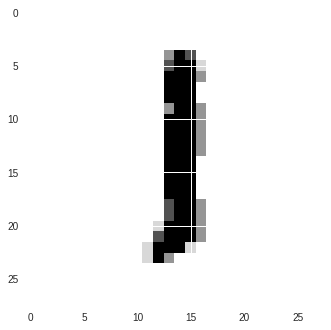

In [0]:
import matplotlib.pyplot as plt
IMGNO=14
plt.imshow(mnist_test_images[IMGNO].reshape(HEIGHT, WIDTH));

In [0]:
def max_out(inputs, num_units, axis=None):
    shape = inputs.get_shape().as_list()
    if shape[0] is None:
        shape[0] = -1
    if axis is None:  # Assume that channel is the last dimension
        axis = -1
    num_channels = shape[axis]
    if num_channels % num_units:
        raise ValueError('number of features({}) is not '
                         'a multiple of num_units({})'.format(num_channels, num_units))
    shape[axis] = num_units
    shape += [num_channels // num_units]
    outputs = tf.reduce_max(tf.reshape(inputs, shape), -1, keep_dims=False)
    return outputs
  
def soft_max_out(inputs, num_units, axis=None,layer = None):
    shape = inputs.get_shape().as_list()
    if shape[0] is None:
        shape[0] = -1
    if axis is None:  # Assume that channel is the last dimension
        axis = -1
    num_channels = shape[axis]
    if num_channels % num_units:
        raise ValueError('number of features({}) is not '
                         'a multiple of num_units({})'.format(num_channels, num_units))
    shape[axis] = num_units
    shape += [num_channels // num_units]
    with tf.variable_scope("softmax{}".format(layer)):
      alpha = tf.get_variable('alpha', shape = [num_units],trainable=True, dtype=tf.float32, initializer = tf.initializers.random_uniform(minval = 1, maxval = 1000,dtype=tf.float32), constraint= tf.keras.constraints.non_neg())
    outputs = (1/alpha)*tf.reduce_logsumexp(tf.expand_dims(alpha,-1)*tf.reshape(inputs,shape),-1,keepdims = False)
    return outputs
  
def linear_model(img):
  X = tf.reshape(img,[-1,HEIGHT*WIDTH]) #flatten
#   X = tf.layers.dropout(X,rate=0.5)

  X = tf.layers.dense(X,1200, activation=None,kernel_constraint = tf.keras.constraints.max_norm(1.9325, axis  = 0))
  X = tf.layers.dropout(X,rate=0.5)
  X = tf.layers.batch_normalization(X)  
#   X = soft_max_out(X,240,layer = 1)#   
  X = tf.contrib.layers.maxout(X,240)

  X = tf.layers.batch_normalization(X)
  X = tf.layers.dense(X,1200, activation=None,kernel_constraint = tf.keras.constraints.max_norm(1.9325, axis  = 0))
#   X = max_out(X,480)
  X = tf.layers.batch_normalization(X)
  X = tf.contrib.layers.maxout(X,240)
#   X = soft_max_out(X,240,layer = 2)
  ylogits = tf.layers.dense(X,NCLASSES,activation=None)
  return ylogits, NCLASSES

In [0]:
def train_input_fn(params):
  return tf.estimator.inputs.numpy_input_fn(
    x={'image':mnist_train_images},
    y=mnist_train_labels,
    batch_size=params['batch_size'],
    num_epochs=None,
    shuffle=True,
    queue_capacity=5000
  )

def eval_input_fn(params): 
  return tf.estimator.inputs.numpy_input_fn(
    x={'image':mnist_test_images},
    y=mnist_test_labels,
    batch_size= params['batch_size'],
    num_epochs=1,
    shuffle=False,
    queue_capacity=5000
  )

def serving_input_fn():
    inputs = {'image': tf.placeholder(tf.float32, [None, HEIGHT, WIDTH])}
    features = inputs # as-is
    return tf.estimator.export.ServingInputReceiver(features, inputs)

In [0]:
def image_classifier(features, labels, mode, params):
  ylogits, nclasses = linear_model(features['image'])
  probabilities = tf.nn.softmax(ylogits)
  classes = tf.cast(tf.argmax(probabilities, 1), tf.uint8)
  
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ylogits, labels=labels))
    evalmetrics =  {'accuracy': tf.metrics.accuracy(classes, tf.argmax(labels, 1))}
    if mode == tf.estimator.ModeKeys.TRAIN:
      train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(),
                                                 learning_rate=params['learning_rate'],
                                                 optimizer= tf.contrib.tpu.CrossShardOptimizer(lambda lr: tf.train.RMSPropOptimizer(learning_rate = lr,momentum = 0.5,epsilon = 0.01)),
                                                 learning_rate_decay_fn = lambda lr,g_step: tf.train.exponential_decay(lr,g_step,1,1/1.00004),)                                            
    else:
      train_op = None
  else:
    loss = None
    train_op = None
    evalmetrics = None
 
  return tf.contrib.tpu.TPUEstimatorSpec(
        mode=mode,
        predictions={"probabilities": probabilities, "classes": classes},
        loss=loss,
        train_op=train_op,
        eval_metric_ops=evalmetrics,
        export_outputs={'classes': tf.estimator.export.PredictOutput({"probabilities": probabilities, "classes": classes})}
    )

In [0]:
def train_and_evaluate(output_dir, hparams):
  estimator = tf.contrib.tpu.TPUEstimator(model_fn = image_classifier,
                                     params = hparams,
                                     config=tf.contrib.tpu.RunConfig(cluster= tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)),
                                     train_batch_size = 512,
                                     model_dir = output_dir,
                                     use_tpu=False)
  train_spec = tf.estimator.TrainSpec(input_fn = train_input_fn,
                                    max_steps = hparams['train_steps'])
  exporter = tf.estimator.LatestExporter('Servo', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn = eval_input_fn,
                                  steps = None,
                                  exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [0]:
OUTDIR='mnist/learned'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

hparams = {'train_steps': 100000, 'learning_rate': 0.025}
train_and_evaluate(OUTDIR, hparams)

In [0]:
OUTDIR='mnist/learned'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

hparams = {'train_steps': 1000, 'learning_rate': 0.01}
train_and_evaluate(OUTDIR, hparams)

In [0]:
for i in range(11,20+1,2):
  print(i)

11
13
15
17
19
